# SpecRNet for Real-Time Deepfake Detection

SpecRNet is a neural network architecture specifically designed for audio deepfake detection that prioritizes speed and accessibility while maintaining competitive accuracy. It addresses the growing threat of audio deepfakes- audio generated using deep neural networks that can be used for impersonation, fake news, and extortion.

The key innovations of SpecRNet include:

1. **Lightweight architecture**: It employs lightweight convolutional layers and residual blocks to reduce computational demands while maintaining high detection accuracy.

2. **Efficiency**: SpecRNet requires up to 40% less processing time per audio sample compared to leading models like LCNN while displaying competitive performance, making it suitable for real-time applications [1](https://arxiv.org/abs/2210.06105).

3. **Low computational requirements**: The architecture is designed to run efficiently on consumer devices, not just high-performance servers.

4. **Feature extraction**: It utilizes spectrograms for audio analysis, which effectively capture both frequency and temporal information.

5. **Integration capabilities**: In advanced implementations, SpecRNet can be combined with other feature extraction methods like Whisper features and Linear Frequency Cepstral Coefficients (LFCC) to enhance multilingual deepfake detection [2](https://pmc.ncbi.nlm.nih.gov/articles/PMC11478486/).

SpecRNet has been benchmarked in three unique settings that confirm its effectiveness: low-resource datasets, detection on short utterances, and limited attacks scenarios. This makes it particularly suitable for analyzing real conversations, which often contain short speech segments from different speakers [1](https://arxiv.org/abs/2210.06105).

For the use case of detecting AI-generated human speech with potential for real-time analysis of conversations, SpecRNet is ideal because:

1. Its focus on speed and efficiency makes it well-suited for real-time low-latency detection scenarios.

2. The architecture's low computational requirements allow for deployment on various devices, including lightweight devices that might be used in conversation monitoring.

3. Its effectiveness on short utterances is particularly valuable for analyzing real conversations, which typically consist of brief speech segments.

4. The model has shown robust performance across different datasets and conditions, suggesting good generalizability to real-world scenarios.

SpecRNet represents a significant advancement in making audio deepfake detection more accessible and practical for everyday applications while maintaining the accuracy needed for reliable detection.

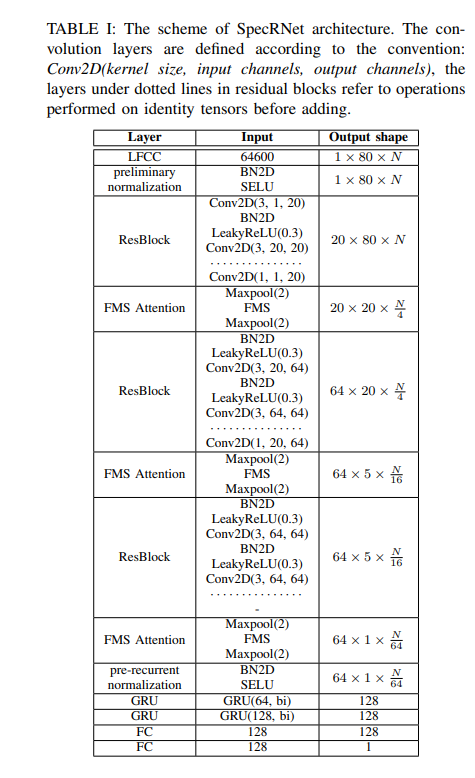

Taken from \
"SpecRNet: Towards Faster and More Accessible Audio DeepFake Detection" \
Piotr Kawa, Marcin Plata and Piotr Syga \
Department of Artificial Intelligence \
Wrocław University of Science and Technology

# Implementation

## Installing Dependencies & Libraries

In [1]:
!git clone https://github.com/piotrkawa/specrnet.git

fatal: destination path 'specrnet' already exists and is not an empty directory.


In [2]:
import os
import torch
import pandas as pd
import numpy as np
import torch
import torchaudio
import librosa
from tqdm.notebook import tqdm

from specrnet.model import SpecRNet


## Audio Preprocessing

In [3]:
DATA_PATH = "/kaggle/input/asvpoof-2019-dataset/LA"
TRAIN_PATH = f"{DATA_PATH}/LA/ASVspoof2019_LA_train/flac"
DEV_PATH = f"{DATA_PATH}/LA/ASVspoof2019_LA_dev/flac"
EVAL_PATH = f"{DATA_PATH}/LA/ASVspoof2019_LA_eval/flac"
PROTOCOL_TRAIN = f"{DATA_PATH}/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
PROTOCOL_DEV = f"{DATA_PATH}/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt"
PROTOCOL_EVAL = f"{DATA_PATH}/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"

In [4]:
def preprocess_audio(audio_dir, protocol_file, max_length=64000, n_mels=80):
    
    df = pd.read_csv(protocol_file, sep=' ', header=None)
    df.columns = ['speaker_id', 'file_name', 'system_id', 'attack_id', 'label']
    
    df['binary_label'] = (df['label'] == 'bonafide').astype(int)
    
    spectrograms = []
    labels = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        file_path = os.path.join(audio_dir, f"{row['file_name']}.flac")
        
        try:
            waveform, sample_rate = torchaudio.load(file_path)
            
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)
            
            if waveform.shape[1] > max_length:
                waveform = waveform[:, :max_length]
            else:
                waveform = torch.nn.functional.pad(
                    waveform, (0, max_length - waveform.shape[1])
                )
            
            mel_spec = torchaudio.transforms.MelSpectrogram(
                sample_rate=sample_rate,
                n_fft=1024,
                hop_length=512,
                n_mels=n_mels
            )(waveform)
            
            mel_spec = torchaudio.transforms.AmplitudeToDB()(mel_spec)

            mean = mel_spec.mean()
            std = mel_spec.std()
            mel_spec = (mel_spec - mean) / std


            spectrograms.append(mel_spec.squeeze().numpy())
            labels.append(row['binary_label'])
            
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    
    return np.array(spectrograms), np.array(labels)

In [5]:
print("Processing training data...")
train_spectrograms, train_labels = preprocess_audio(TRAIN_PATH, PROTOCOL_TRAIN)
print("Processing validation data...")
dev_spectrograms, dev_labels = preprocess_audio(DEV_PATH, PROTOCOL_DEV)

X_train = np.expand_dims(train_spectrograms, axis=1)
X_dev = np.expand_dims(dev_spectrograms, axis=1)
y_train = train_labels
y_dev = dev_labels

Processing training data...


  0%|          | 0/25380 [00:00<?, ?it/s]

Processing validation data...


  0%|          | 0/24844 [00:00<?, ?it/s]

In [6]:
np.savez_compressed("asvspoof_data.npz",
                    X_train=X_train,
                    y_train=y_train,
                    X_dev=X_dev,
                    y_dev=y_dev)

## Training
SpecRNet is designed to be trained from scratch on data, instead of a pretrained model to allow for higher speed and accesibility.

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torch
from tqdm.notebook import tqdm

from specrnet.model import SpecRNet
import matplotlib.pyplot as plt

In [8]:
data = np.load("asvspoof_data.npz")
X_train = data['X_train']
y_train = data['y_train']
X_dev = data['X_dev']
y_dev = data['y_dev']

In [9]:
'''
y_train_insane = np.random.permutation(y_train)             SANITY CHECK
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_train).float(),
    torch.tensor(y_train_insane, dtype=torch.long)
)
'''
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_train).float(),
    torch.tensor(y_train, dtype=torch.long)
)


dev_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_dev).float(),
    torch.tensor(y_dev, dtype=torch.long)
)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

In [10]:
d_args = {
    "filts": [
        [1],
        [1, 32],
        [32, 64],
    ],
    "gru_node": 256,
    "nb_gru_layer": 2,
    "nb_fc_node": 128,
    "nb_classes": 1
}


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpecRNet(d_args).to(device)

model.eval()

epochs = 10
learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [11]:
criterion = nn.BCEWithLogitsLoss()

In [12]:
train_losses, train_accuracies, val_losses, val_accuracies = [],[],[],[]

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

# --- Training Loop with Metrics ---
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]"):
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        predicted = (torch.sigmoid(outputs) >= 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct * 100 / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # --- Training Precision, Recall, F1 ---
    all_preds_train = []
    all_labels_train = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.unsqueeze(1).float()
            outputs = model(inputs)
            predicted = (torch.sigmoid(outputs) >= 0.5).float()
            all_preds_train.extend(predicted.cpu().numpy())
            all_labels_train.extend(labels.cpu().numpy())

    train_precision = precision_score(all_labels_train, all_preds_train, zero_division=0)
    train_recall = recall_score(all_labels_train, all_preds_train, zero_division=0)
    train_f1 = f1_score(all_labels_train, all_preds_train, zero_division=0)

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds_val = []
    all_labels_val = []

    with torch.no_grad():
        for inputs, labels in tqdm(dev_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]"):
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.unsqueeze(1).float()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            predicted = (torch.sigmoid(outputs) >= 0.5).float()

            all_preds_val.extend(predicted.cpu().numpy())
            all_labels_val.extend(labels.cpu().numpy())

            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= val_total
    val_acc = val_correct * 100 / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    val_precision = precision_score(all_labels_val, all_preds_val, zero_division=0)
    val_recall = recall_score(all_labels_val, all_preds_val, zero_division=0)
    val_f1 = f1_score(all_labels_val, all_preds_val, zero_division=0)

    # --- Print Everything ---
    print(f"\nEpoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1: {train_f1:.2f}")
    print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.2f}% | Precision: {val_precision:.2f}, Recall: {val_recall:.2f}, F1: {val_f1:.2f}")


Epoch 1/10 [Training]:   0%|          | 0/794 [00:00<?, ?it/s]

Epoch 1/10 [Validation]:   0%|          | 0/777 [00:00<?, ?it/s]


Epoch 1/10
Train Loss: 0.0821, Train Acc: 96.85% | Precision: 1.00, Recall: 0.98, F1: 0.99
Val   Loss: 0.0248, Val   Acc: 99.31% | Precision: 1.00, Recall: 0.93, F1: 0.97


Epoch 2/10 [Training]:   0%|          | 0/794 [00:00<?, ?it/s]

Epoch 2/10 [Validation]:   0%|          | 0/777 [00:00<?, ?it/s]


Epoch 2/10
Train Loss: 0.0131, Train Acc: 99.60% | Precision: 0.99, Recall: 1.00, F1: 0.99
Val   Loss: 0.0048, Val   Acc: 99.82% | Precision: 0.99, Recall: 0.99, F1: 0.99


Epoch 3/10 [Training]:   0%|          | 0/794 [00:00<?, ?it/s]

Epoch 3/10 [Validation]:   0%|          | 0/777 [00:00<?, ?it/s]


Epoch 3/10
Train Loss: 0.0071, Train Acc: 99.77% | Precision: 1.00, Recall: 0.99, F1: 0.99
Val   Loss: 0.0153, Val   Acc: 99.49% | Precision: 1.00, Recall: 0.95, F1: 0.97


Epoch 4/10 [Training]:   0%|          | 0/794 [00:00<?, ?it/s]

Epoch 4/10 [Validation]:   0%|          | 0/777 [00:00<?, ?it/s]


Epoch 4/10
Train Loss: 0.0080, Train Acc: 99.76% | Precision: 0.94, Recall: 0.99, F1: 0.96
Val   Loss: 0.0224, Val   Acc: 99.23% | Precision: 0.94, Recall: 0.99, F1: 0.96


Epoch 5/10 [Training]:   0%|          | 0/794 [00:00<?, ?it/s]

Epoch 5/10 [Validation]:   0%|          | 0/777 [00:00<?, ?it/s]


Epoch 5/10
Train Loss: 0.0046, Train Acc: 99.87% | Precision: 1.00, Recall: 1.00, F1: 1.00
Val   Loss: 0.0127, Val   Acc: 99.77% | Precision: 1.00, Recall: 0.98, F1: 0.99


Epoch 6/10 [Training]:   0%|          | 0/794 [00:00<?, ?it/s]

Epoch 6/10 [Validation]:   0%|          | 0/777 [00:00<?, ?it/s]


Epoch 6/10
Train Loss: 0.0081, Train Acc: 99.78% | Precision: 1.00, Recall: 1.00, F1: 1.00
Val   Loss: 0.0097, Val   Acc: 99.81% | Precision: 1.00, Recall: 0.98, F1: 0.99


Epoch 7/10 [Training]:   0%|          | 0/794 [00:00<?, ?it/s]

Epoch 7/10 [Validation]:   0%|          | 0/777 [00:00<?, ?it/s]


Epoch 7/10
Train Loss: 0.0036, Train Acc: 99.90% | Precision: 1.00, Recall: 1.00, F1: 1.00
Val   Loss: 0.0022, Val   Acc: 99.96% | Precision: 1.00, Recall: 1.00, F1: 1.00


Epoch 8/10 [Training]:   0%|          | 0/794 [00:00<?, ?it/s]

Epoch 8/10 [Validation]:   0%|          | 0/777 [00:00<?, ?it/s]


Epoch 8/10
Train Loss: 0.0032, Train Acc: 99.92% | Precision: 1.00, Recall: 0.99, F1: 1.00
Val   Loss: 0.0056, Val   Acc: 99.88% | Precision: 1.00, Recall: 0.99, F1: 0.99


Epoch 9/10 [Training]:   0%|          | 0/794 [00:00<?, ?it/s]

Epoch 9/10 [Validation]:   0%|          | 0/777 [00:00<?, ?it/s]


Epoch 9/10
Train Loss: 0.0084, Train Acc: 99.81% | Precision: 1.00, Recall: 1.00, F1: 1.00
Val   Loss: 0.0033, Val   Acc: 99.92% | Precision: 1.00, Recall: 0.99, F1: 1.00


Epoch 10/10 [Training]:   0%|          | 0/794 [00:00<?, ?it/s]

Epoch 10/10 [Validation]:   0%|          | 0/777 [00:00<?, ?it/s]


Epoch 10/10
Train Loss: 0.0028, Train Acc: 99.91% | Precision: 1.00, Recall: 1.00, F1: 1.00
Val   Loss: 0.0135, Val   Acc: 99.55% | Precision: 1.00, Recall: 0.96, F1: 0.98


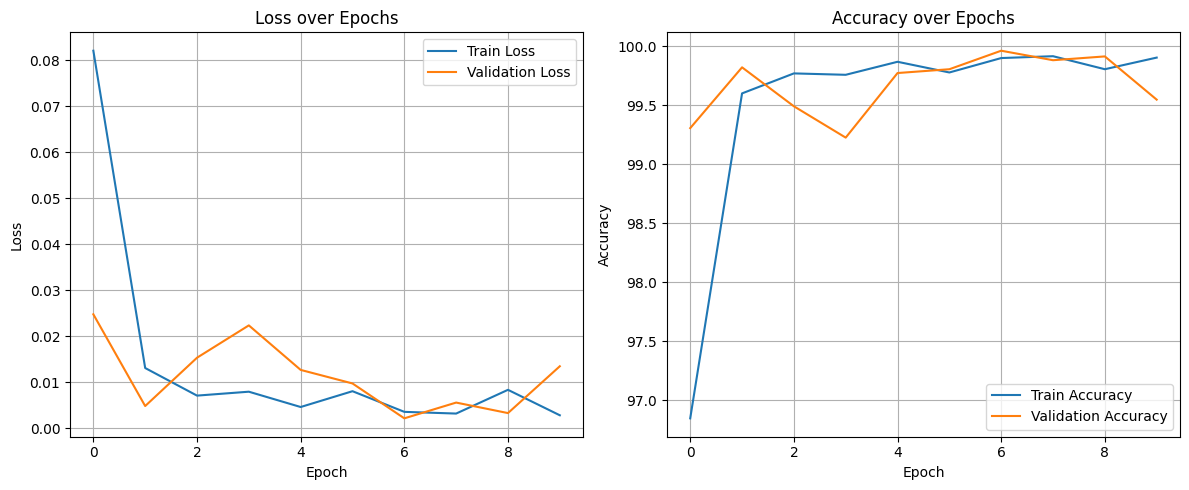

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [15]:
torch.save({
    'model_state_dict': model.state_dict(),
}, "asvspoof_model.pth")


## Testing

In [17]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import librosa
from tqdm import tqdm
from specrnet.model import SpecRNet
from sklearn.metrics import confusion_matrix, roc_curve
import matplotlib.pyplot as plt

DATA_PATH = "/kaggle/input/asvpoof-2019-dataset/LA"
EVAL_PATH = f"{DATA_PATH}/LA/ASVspoof2019_LA_eval/flac"
PROTOCOL_EVAL = f"{DATA_PATH}/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"

sample_rate = 16000

d_args = {
    "filts": [
        [1],
        [1, 32],
        [32, 64],
    ],
    "gru_node": 256,
    "nb_gru_layer": 2,
    "nb_fc_node": 128,
    "nb_classes": 1
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpecRNet(d_args).to(device)

trained = torch.load("asvspoof_model.pth")
model.load_state_dict(trained['model_state_dict'])
model.eval()

class ASVspoofEvalDataset(Dataset):
    def __init__(self, protocol_path, audio_base):
        self.audio_base = audio_base
        self.files = []
        self.labels = []

        with open(protocol_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                filename = parts[1]
                label = 1 if parts[-1] == "bonafide" else 0
                self.files.append(filename)
                self.labels.append(label)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_id = self.files[idx]
        label = self.labels[idx]

        audio_path = os.path.join(self.audio_base, file_id + ".flac")
        y, sr = librosa.load(audio_path, sr=sample_rate)

        mel = librosa.feature.melspectrogram(
            y=y, sr=sr, n_fft=512, hop_length=160, win_length=400, n_mels=80
        )
        log_mel = librosa.power_to_db(mel)
        log_mel = (log_mel - np.mean(log_mel)) / (np.std(log_mel) + 1e-6)

        target_width = 400
        if log_mel.shape[1] < target_width:
            pad_width = target_width - log_mel.shape[1]
            log_mel = np.pad(log_mel, ((0,0),(0,pad_width)), mode='constant')
        else:
            log_mel = log_mel[:, :target_width]

        log_mel = torch.tensor(log_mel).unsqueeze(0).float()
        return log_mel, torch.tensor(label).float()

eval_dataset = ASVspoofEvalDataset(PROTOCOL_EVAL, EVAL_PATH)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []
all_scores = []

with torch.no_grad():
    for inputs, labels in tqdm(eval_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        scores = torch.sigmoid(outputs).squeeze()

        predicted = (scores >= 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_scores.extend(scores.cpu().numpy())

eval_acc = correct / total
print(f"\nEval Set Accuracy: {eval_acc * 100:.2f}%")

<ipython-input-17-b541a92110be>:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained = torch.load("asvspoof_model.pth")
100%|██████████| 2227/2227 [21:39<00:00,  1.71it


Eval Set Accuracy: 88.01%


The model achieves ~89% sccuracy as described in the landmark research paper that introduced SpecRNet. However, due to the class imbalance within the ASVSpoof dataset and overfitting of the model along with the difference in distributions for the train/validation and test sets, it struggles with precision and recall in the test set.

This can be relieved through the following:
1. Regularization within a customized SpecRNet model, (ex. adding dropout regularization in between layers),
2. Upsampling the spoofed data, downsampling the bonafide data to prevent bias towards one particular class, and
3. Using class weighted terms in the loss function, prioritizing spoofed samples.
   
The efficacy of these methods for this particular use case, though, need to be further implemented and measured.